# Classification

In [1]:
import numpy as np
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

## 1.) Load data and Build Model

Import MNIST dataset from sklearn. The dataset contains 70k small images of digits handwritten by high school students and employees of US Census Bureau. Often known as Hello word Program of Machine Learning.

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
#Let's look at the dataset

X,y = mnist["data"],mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


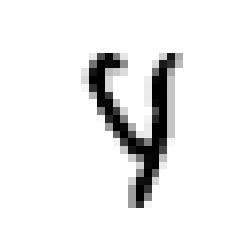

In [4]:
#Let's check one of the entry

#the images are 28 X 28 pixels and each feature simply represents one pixel's intensity, so there are 784 features. 

#to check one entry we are grabbing an instance's feature vector, 
#reshape it to 28 X 28 array and display it using Matplotlib imshow() fucntion.

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[25000]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")

plt.axis("off")
plt.show()

In [5]:
# Now check target variable and see if it looks like 4.

y[25000]

4.0

In [6]:
#Create a test set and set it aside before inspecting data closely. 
#MNIST dataset is already split into training and testing set ( the first 60 k rows are training and last 10k rows are test set)

#Also we will shuffle the training set so that all cross validation folds will be similar 
#( it wo't be good if our training set miss some digits)


import numpy as np

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [7]:
#See some entries
X_train


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

For simplification, we will only try to identify one digit . So our classifier will be binary classifier which is capable of distinguishing b/w just two classes "4" and "not 4"

In [8]:
y_train_4 = (y_train == 4)
y_test_4 = (y_test == 4)

In [9]:
#Now let's pick a classifier and train it. Let's use SGD classifier (Stochastic Gradient Descent)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_4)

#SGD classifier relies on randomness during training, to produce reproducible results, we have to set random_state parameter

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
#Now let's predict the images of number 4

sgd_clf.predict([some_digit])

array([ True])

Looks like our model predicted number 4 correctly. It's time to evaluate the model's performance

## 2.) Performance Measures

### 2.1) Measuring Accuracy Using Cross-Validation

In [11]:
#We can implement cross validation using scikit learn StratifiedKFold

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_4):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_4[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_4[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.9641017949102545
0.98015
0.9733986699334967


## 2.2) Measuring accuracy Using cross_val_score() function

In [12]:
#using cross_val_score() function to evaluate SGD classifier model using K-fold cross validation

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_4, cv =3, scoring = 'accuracy')

array([0.96410179, 0.98015   , 0.97339867])

We can see our accuracy is above 95% on all cross-valdation folds. Amazing, no? But, let's check a very dumb classifier which 
classifies every single image as "not-4" class.

In [13]:
from sklearn.base import BaseEstimator

#there are two functions in the class Never4Classifier, fit() and predict()

class Never4Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass #do nothing
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) #return an array of 'len(X) * 1' with all elements as zero in bool (false)
        
    
never_4_clf = Never4Classifier() #Create an object of class Never4Classifier
cross_val_score(never_4_clf, X_train, y_train_4, cv=3, scoring='accuracy')

array([0.9039, 0.9027, 0.9013])

This means even a dumb classifier which predicts everything as "not-4" also gives us an accuracy of more than 90%. Why?
This is simply because only 10% of the data images are 4, so if you guess all the data as 'not-4', you are right more than 90% of the time.

This means, accuracy is not the prefereed measure when you have skewed datasets. so, what's next?

## Confusion Matrix

Confusion Matrix is a simple idea of counting the number of times instances of the class A are classified as class B. For example, in a multi class classification for this dataset, to know the number of times classifier confused images of 5s with images of 3, you would look 5th row and 3rd column of the confusion matrix.

![alt text](Confusion_Matrix1_1.png "Confusion Matrix")

To compute confusion matrix, we need to have set of predictions first and then compared to actual targets. But, for now, we will do it on validation set, because we should do predictions on test set only once.

for this, we can  use cross_val_predict() function, which does cross validation and instead of returning accuracy scores, it returns the predictions made on each test fold.

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_4, cv =3)


#Now, we can use confusion matrix() func. We just simply need to pass target classes (y_train_4) and pred classes (y_train_pred)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_4, y_train_pred)

array([[53278,   880],
       [  767,  5075]], dtype=int64)

The above matrix tells us:

1st row is Negatives -

*53278* are not 4s and are correctly classified as 'not-4'  - TRUE NEGATIVES (TN)

*880* are not 4s but are classified as 4 - FALSE POSITIVES (FP)

2nd Row is Positives - 

*767* are 4s but wrongly classified as 'not-4' - FALSE NEGATIVES (FN)

*5075* are 4s and correctly calssified as 4 - TRUE POSITIVES (TP)


A Perfect classifier would be which have only TRUE NEGATIVES (TN) and TRUE POSITIVES (TP) . So there would be zeroes for FALSE POSITIVES (FP) and FALSE NEGATIVES (FN)

In [15]:
#If all predictions are same as target

y_train_perfect_predictions = y_train_4
confusion_matrix(y_train_4, y_train_perfect_predictions)

array([[54158,     0],
       [    0,  5842]], dtype=int64)

## Precision, Recall, F1 Score

Precision is accuracy of positive predictions.

**precision** = $TP/(TP+FP)$, which means how many are true positives out of total positives.


Recall is ratio of positive instances that are correctly detected by the classifier

**recall**, **sensitivity** or **true positive rate** = $TP/(TP+FN)$, how many are true positives out of correctly classified.


**F1 Score** = harmonic mean of precision and recall. this can be used to compare two classifiers, the higher the harmonic mean, the better the classifier is.

F1 = $ TP/(TP + ((FN + FP)/2)) $

In [16]:
#Precision and recall

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_4, y_train_pred) # 5075/(5075+880) 

0.852225020990764

In [17]:
recall_score(y_train_4, y_train_pred) # 5075(5075+767)

0.8687093461143444

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_4, y_train_pred)

0.8603882342968552

## Precision Recall Tradeoff

Increasing Precision reduces recall and vice versa.

Scikit learn gives access to decision scores that it uses to make predictions. Instead of calling the classifier predict() method, we can call it decision_function, which returns a score for each instance and then make prediction on the based of the threshold you want.

In [19]:
y_scores = sgd_clf.decision_function([some_digit])

y_scores

array([140293.09454614])

In [20]:
#When threshold is zero, the result is same as predict method

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
#Now let's chnage some threshold above than decision score. We can see that prediction is false now.

threshold = 200000

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

So, how to decide which threshold to use?

For this, we first need to get the scores of all instances (example) using cross_val_predict() function, but instead of predictions we will get decision scores.

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_4, cv = 3, method="decision_function")

Once we have these scores, we can compute precision and recall for all possible threshold using the precision_recall_curve() function

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_4, y_scores)

And Finally, we can plot precision and recall as function of threshold value using Matplotlib

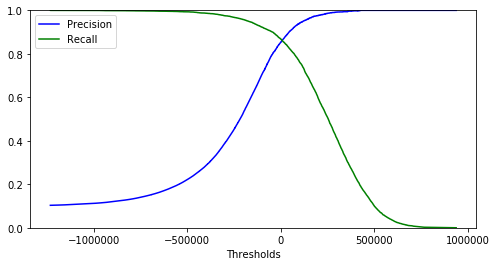

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,precisions[:-1],"b-", label = "Precision")
    plt.plot(thresholds,recalls[:-1], "g-", label = "Recall")
    plt.xlabel("Thresholds")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
    

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

Another way is to plot precision directly against recall and then observe this graph. You will probably want to select a precision/recall tradeoff just before the sharp drop. But then it depends on the project.

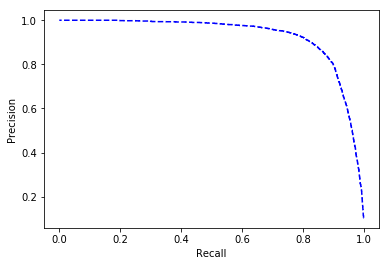

In [25]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls,precisions,"b--")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    

plot_precision_vs_recall(precisions,recalls)
plt.show()

Now let's suppose you want a precision of 90%, so from the graph above the above graph tells us that you can get precision of 90% at the threshold above 40000. so, to make predictions ,instead of calling predict(), we can simply run below code. 

In [26]:
y_train_pred_90 = (y_scores > 40000)

In [27]:
#Let's check precision and recall with the new threshold 

print(precision_score(y_train_4, y_train_pred_90))
print(recall_score(y_train_4, y_train_pred_90))

0.8946691176470588
0.8331051009928107


# If someone says let's reach 99% precision, you should ask, "at which recall?"

## The ROC curve

Receiver operating characterstic (ROC) curve is very similar to precision/recall curver, but instead of plotting precision vs recall, the ROC curve plots the true positive rate (recall) against the false positive rate. 

FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 minus true negative rate, which is ratio of negative instances that are correctly classified as negative.

TNR is also know as specificity

Hence ROC curves plot recall(sensitivity) vs 1-specificity



In [28]:
#import the roc_curve and calculate TPR, FPR for various thresholds.

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_4, y_scores)

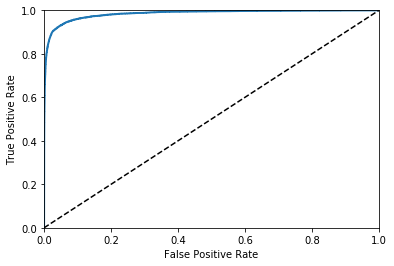

In [29]:
#plot FPR vs TPR 

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    
plot_roc_curve(fpr,tpr)
plt.show()

We can use **Area under the curve (AUC)** to compare classifiers, A perfect classifier will have ROC AUC equal to 1, whereas a purely random classifier will have ROC AUC equal to 0.5

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_4, y_scores)

0.9842328655607044

### Which curve to use ROC or PR?

As a rule of thumb, we should prefer PR curve when poitive class is rare or when we care more about false positives than false negatives, and the ROC curve otherwise.

## Performance measure for different classifiers 

Let's measure **RandomForestClassifier** and **SGDClassifier** and compare their **ROC Curve** and **ROC AUC curve** 

In [31]:
#import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_4, cv=3, method ='predict_proba')

c:\users\vivekanand.joshi\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [32]:
#change probablities into scores. We will use poitive class probablities as their scores.

y_scores_forest = y_probas_forest[:,1] #score = proba of positive class


fpr_forest, tpr_forest,thresholds_forest = roc_curve(y_train_4, y_scores_forest)

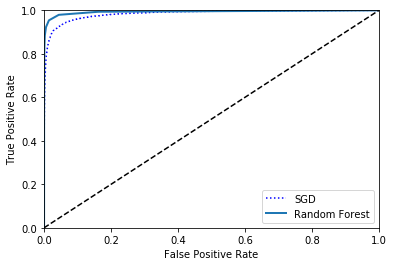

In [33]:
#Plot ROC curve

plt.plot(fpr,tpr,"b:", label = "SGD")
plot_roc_curve(fpr_forest,tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [34]:
#Check ROC AUC score for RandomForestClassifier

roc_auc_score(y_train_4, y_scores_forest)

0.9934110506847609

In [35]:
#print precision and recall score for RandomForestClassifier

y_train_pred_rf = cross_val_predict(forest_clf, X_train, y_train_4, cv=3)

print(precision_score(y_train_4, y_train_pred_rf))
print(recall_score(y_train_4, y_train_pred_rf))

0.9896003262642741
0.8307086614173228


# Multiclass Classification

 For distinguishing more than 2 classes.
 
 **One-versus-all (OvA)** and **One-versus-one(OvO)** strategy.
 
 **OvA** - Make N binary classifier. Then get the decision score for each classifier and select the one with the highest.
 
 **OvO** - If there are N classes, $N*(N-1)/2$ classifiers and see which class wins the most duels.

In [36]:
#scikit learn automatically run OvA (except for SVM classifiers for which it uses OvO)

sgd_clf.fit(X_train, y_train) #for all classes and not only for not-4 class
sgd_clf.predict([some_digit])

array([4.])

In [37]:
#under the hood scikit learn ran 10 binary classifiers and selected the output with largest decision_function() method.
#We can check scores for each binary classifier and see if this actually happens. 4 indeed has highest score.

some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-645260.48289265, -360266.47541517, -303811.3159005 ,
        -290139.1913401 ,  140293.09454614, -179742.03367284,
        -344903.24774767, -163059.04697424, -233877.8726477 ,
         -77063.01266331]])

In [38]:
np.argmax(some_digit_scores)

4

In [39]:
#to force OneVsOneClassifier in sckit learn we can create an instance of it.

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

array([4.])

In [40]:
#check how many classifiers were created

len(ovo_clf.estimators_)

45

In [41]:
#Let's train a multiclass RandomForestClassifier

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([4.])

In [42]:
#Since RandomForestClassifier can directly classify instances into multiple classes, scikit-learn doesn't have to run OvO or OvA
#We can check probablities for each class. We can see 4th has highest probability.

forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0.8, 0. , 0. , 0.1, 0. , 0. ]])

In [43]:
#Scaling to get better results. 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train,cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

# Error Analysis 

In [44]:
#We need to make predictions using the cross_val_predict() function and then call a confusion_matrix() function

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]],
      dtype=int64)

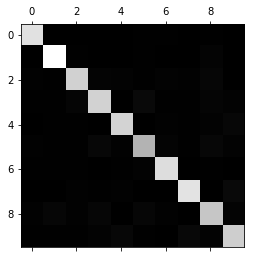

In [45]:
#We can create an image representation as well for the above matrix.

plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

The confusion matrix looks fairly good, since most of the images are on the main diagonal which means they were correctly classified. The 5 is slightly darker than other digits, why? there could be two reasons, first, that there are few images of 5, second, classifier doesn't perform well on 5s as on other digits.

Let's focus on errors now.

1.) We divide each value in the confusion matrix by the number of images in each class.

2.) Now fill diagonals with zeros to keep only the errors.

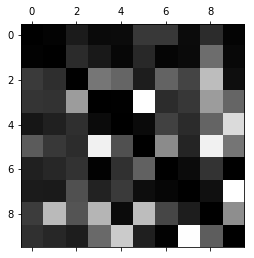

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums


np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

#ROWS = Actual Classes
#COLUMNS = Predicted Classes

The above figure helps us to know where we need to focus to make our predictions better. for example, 3 and 5 classifier doesn't perform well

8 and 9 classifiers are not predicting good.

## Multilabel Classification

In some cases, you would want your classifier predict multiple classes for one instance. for example, in a face recognition classifier, one image can have three faces. For example if classifier is recognize to identify three faces, Alice, Bob, Charles, then when it is shown a picture which has Alice and Charles in it it should predict **1, 0, 1**. 

Such a classification is called multilabeled classification. 

In [47]:
#let's create two labels, large digit (7,8,9) and odd number

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train%2 ==1)
y_multilabel = np.c_[y_train_large,y_train_odd]


knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [48]:
knn_clf.predict([some_digit])

array([[False, False]])

This is right as 4 is neither large, nor odd

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv =3)
f1_score(y_train,y_train_knn_pred, average = "macro")

# Exercises

## Exercise 1 - Build a MNIST classifier with over 97% accuracy.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf_ex = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf_ex.fit(X_train,y_train)

In [ ]:
y_knn_pred = knn_clf_ex.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

The question is how to get the above hyper-parameters? For this we need to import GridSearchCV

We need to import GridSearchCV and set different parameters as a list. The classifier will run the model for all possible combinations. 

Then we can find best parameters as per highest metric through grid_search.best_params_ and grid.search.best_score_

In [ ]:
#Set a parameter grids with different options and run the classifier with different permutations.

from sklearn.model_selection import GridSearchCV

param_grid =[{'weights':["uniform","distance"], 'n_neighbors':[3,4,5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid,cv=5,verbose =3, n_jobs =-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
